# This script implements Autoencoder for MNIST dataset
1. Conv_Autoencoder with convolutional layers
2. MLP_Autoencoder with only Linear layers

Some background on convolutin and conv transpose are also provided. <br/>
For analyzing results, we not only plot the comparison between original and reconstructed images,
but also plot the linear interpolation between any two input images. A smooth transition can be observed

In [1]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [2]:
# set seed for reproducibility
seed = 24
torch.manual_seed(seed)
np.random.seed(seed)

## Load Dataset

In [3]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

In [4]:
batch_size = 32

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="../data/", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root="../data/", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Divert: Transpose of convolutional layer

In [5]:
conv = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5)

In [6]:
x = torch.randn(2, 8, 64, 64)
y = conv(x)
print(y.shape)

torch.Size([2, 8, 60, 60])


A convolution transpose layer with the exact same specifications as above would have the "reverse" effect on the shape

In [7]:
convt = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=5)
print(convt(y).shape) # should be same as x

torch.Size([2, 8, 64, 64])


Add some padding

In [8]:
conv = nn.Conv2d(in_channels=8, out_channels=16, 
                 kernel_size=5, padding=1)

In [9]:
y = conv(x)
print(y.shape)

torch.Size([2, 16, 62, 62])


In [10]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8,
                          kernel_size=5, padding=1)
print(convt(y).shape)

torch.Size([2, 8, 64, 64])


Add some stride

In [11]:
conv = nn.Conv2d(in_channels=8, out_channels=16,
                kernel_size=7, stride=2, padding=3)
y = conv(x)
print(y.shape)

torch.Size([2, 16, 32, 32])


In [12]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8,
                           kernel_size=7, stride=2, 
                           output_padding=1, # needed because of stride, set to 1 for stride=2
                           padding=3)
print(convt(y).shape)

torch.Size([2, 8, 64, 64])


## Autoencoder

A complex convolutional autoencoder

In [13]:
# class Conv_Autoencoder(nn.Module):
#     def __init__(self):
#         super(Conv_Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, 3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, 7)
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, 7),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid() # push the pixels in range (0,1)
#         )
        
#     def forward(self, x):
#         latent = self.encoder(x)
#         reconstruction = self.decoder(latent)
#         return latent, reconstruction

A much simpler MLP autoencoder

In [14]:
class MLP_Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(MLP_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=kwargs["input_shape"], out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=kwargs["latent_dim"])
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=kwargs["latent_dim"], out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=kwargs["input_shape"]),
            nn.Sigmoid() # push the pixels in range (0,1)
        )
        
    def forward(self, x):
        B, C, H, W = x.shape
#         x = x.view(B, -1)
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        reconstruction = reconstruction.reshape(B, C, H, W)
        return latent, reconstruction

## Training process

In [15]:
def train(model, device, train_loader, num_epochs=5, learning_rate=1e-3):
    recon_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
                          weight_decay=1e-5)
    history = []
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for img, label in train_loader:
            optimizer.zero_grad()
            
            img = img.to(device)
            latent, reconstruction = model(img)
            loss = recon_loss(img, reconstruction)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
        train_loss = train_loss/len(train_loader)
        if (epoch<5) or (epoch%5 == 0):
            print("Epoch {}, Loss {:.4f}".format(epoch+1, float(train_loss)))
        history.append((epoch, img, reconstruction, latent),)
    
    return history   

In [24]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
C, H, W = 1, 28, 28

# model = Conv_Autoencoder().to(device) 
model = MLP_Autoencoder(input_shape=784, latent_dim=8).to(device)
num_epochs = 2
history = train(model, device, train_loader, num_epochs=num_epochs)

Epoch 1, Loss 0.0436
Epoch 2, Loss 0.0292


## Visualization of the training process and results

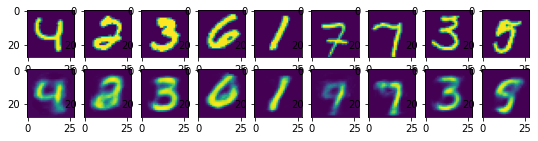

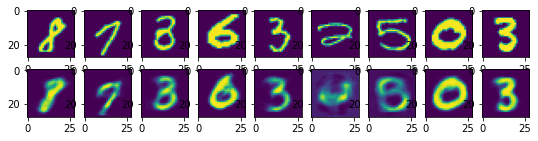

In [25]:
for k in range(0, 2, 1):
    plt.figure(figsize=(9,2))
    imgs = history[k][1].cpu().detach().numpy()
    reconstructions = history[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        # plot only first few images
        if i>=9: break
        plt.subplot(2,9, i+1)
        plt.imshow(item[0])
    
    for i, item in enumerate(reconstructions):
        if i>=9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [26]:
sample_img = history[-1][1].cpu().detach().numpy()
sample_reconstruction = history[-1][2].cpu().detach().numpy()
sample_latent = history[-1][3].cpu().detach().numpy()
print(sample_img.shape, sample_reconstruction.shape, sample_latent.shape)

(32, 1, 28, 28) (32, 1, 28, 28) (32, 8)


## Structure in the embeddings

Choose images of the same digit for comparison

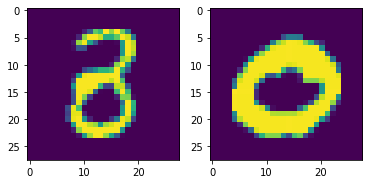

In [27]:
imgs = history[num_epochs-1][1].cpu().detach().numpy()
idx1 = 2
idx2 = 7
plt.subplot(1,2,1)
plt.imshow(imgs[idx1][0])
plt.subplot(1,2,2)
plt.imshow(imgs[idx2][0])

In [28]:
x1 = history[num_epochs-1][1][idx1,:,:,:] # first image
x2 = history[num_epochs-1][1][idx2,:,:,:] # first image
x = torch.stack([x1, x2])
print("x", x.shape, "x1", x1.shape)
embedding = model.encoder(x)
e1 = embedding[0]
e2 = embedding[1]
e1.shape

x torch.Size([2, 1, 28, 28]) x1 torch.Size([1, 28, 28])


torch.Size([8])

### Interpolation between two embeddings

In [30]:
embedding_values = []
for i in range(10):
    e = e1 * (i/10) + e2 * (10-i)/10
    embedding_values.append(e)
embedding_values = torch.stack(embedding_values)
recon_from_embeddings = model.decoder(embedding_values)
if len(recon_from_embeddings.shape) == 2:
    B, _ = recon_from_embeddings.shape
    recon_from_embeddings = recon_from_embeddings.reshape(B, C, H, W)
recon_from_embeddings.shape

torch.Size([10, 1, 28, 28])

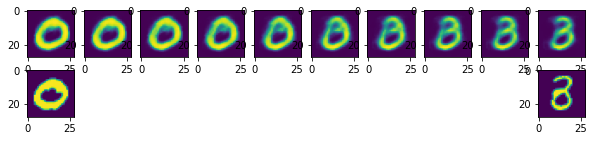

In [31]:
plt.figure(figsize=(10,2))
for i, recon in enumerate(recon_from_embeddings.cpu().detach().numpy()):
    plt.subplot(2, 10, i+1)
    plt.imshow(recon[0])
# plot two original images
plt.subplot(2, 10, 11)
plt.imshow(imgs[idx2][0])
plt.subplot(2, 10, 20)
plt.imshow(imgs[idx1][0])

### Interpolation between any two images

In [32]:
def interpolate(index1, index2, batch_idx=1):
    x1 = history[num_epochs-1][batch_idx][index1]
    x2 = history[num_epochs-1][batch_idx][index2]
    x = torch.stack([x1, x2])
    embedding = model.encoder(x)
    e1 = embedding[0]
    e2 = embedding[1]
    
    embedding_values = []
    for i in range(10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)
    recon_from_embeddings = model.decoder(embedding_values)
    if len(recon_from_embeddings.shape) == 2:
        B, _ = recon_from_embeddings.shape
        recon_from_embeddings = recon_from_embeddings.reshape(B, C, H, W)
    recon_from_embeddings.shape
    
    plt.figure(figsize=(10,2))
    for i, recon in enumerate(recon_from_embeddings.cpu().detach().numpy()):
        plt.subplot(2, 10, i+1)
        plt.imshow(recon[0])
    # plot two original images
    plt.subplot(2, 10, 11)
    plt.imshow(x2.cpu().detach().numpy()[0])
    plt.subplot(2, 10, 20)
    plt.imshow(x1.cpu().detach().numpy()[0])

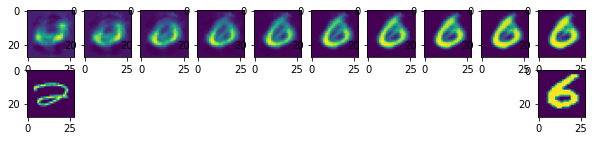

In [33]:
interpolate(3,5)

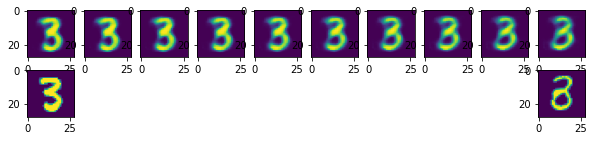

In [34]:
interpolate(2,8)

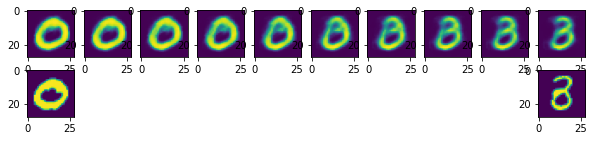

In [35]:
interpolate(2,7)